In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load dataset
dataset=pd.read_csv('./iris.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#Show Key Statistics
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


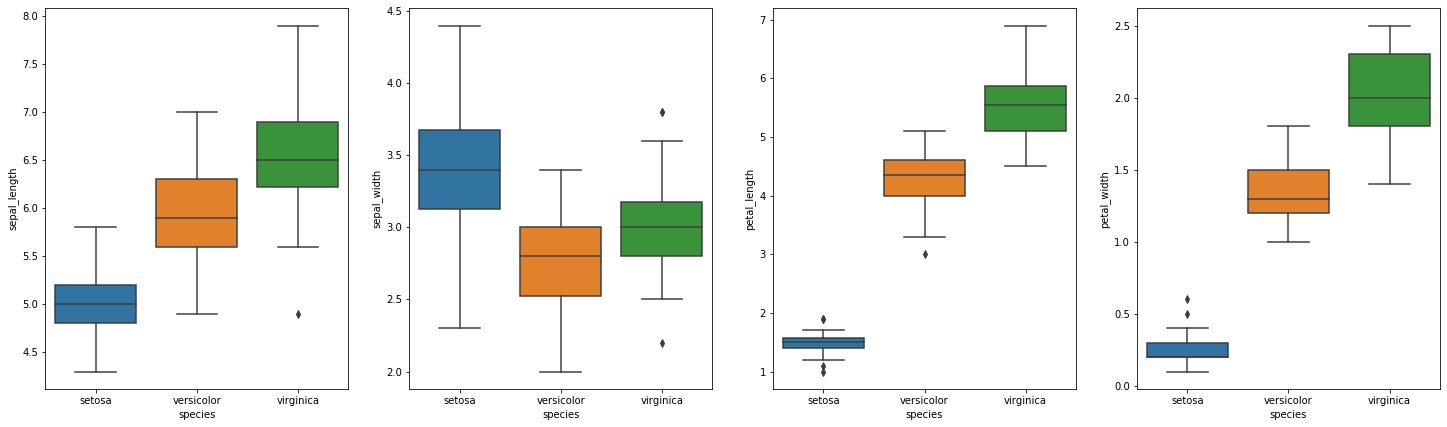

In [4]:
# Boxplot of Features

fig,ax=plt.subplots(nrows=1 ,ncols=4)

sns.boxplot(data=dataset,y='sepal_length',x='species',ax=ax[0])
sns.boxplot(data=dataset,y='sepal_width',x='species',ax=ax[1])
sns.boxplot(data=dataset,y='petal_length',x='species',ax=ax[2])
sns.boxplot(data=dataset,y='petal_width',x='species',ax=ax[3])
fig.set_figwidth(25)
fig.set_figheight(7)

In [5]:
# importing package
import pandas_profiling as pp
from IPython.display import IFrame

# Profile Report
dataset2 = pp.ProfileReport(dataset)
dataset2.to_file('irisLDA.html')
display(IFrame('irisLDA.html', width=900, height=350))

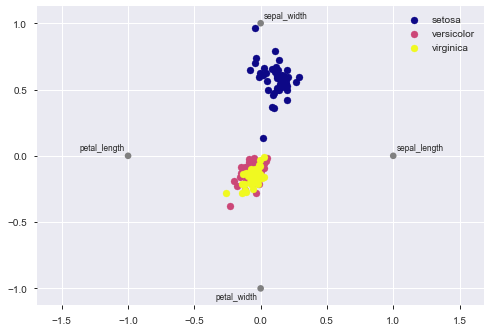

In [6]:
# Multidimensional dataset in 2D. 
# Colors can be found at https://matplotlib.org/users/colormaps.html
from pandas.plotting import radviz
radviz(dataset, 'species',colormap='plasma')

In [7]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
Y = dataset['species'].values

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Import Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
#Class Balance - Test Data
print('Train Data - Class Split')
num_setosa = (y_train_smt == 'setosa').sum()
num_versicolor = (y_train_smt == 'versicolor').sum()
num_virginica = (y_train_smt == 'virginica').sum()
print('setosa -',  num_setosa)
print('versicolor -',  num_versicolor)
print('virginica -',  num_virginica)

Train Data - Class Split
setosa - 40
versicolor - 40
virginica - 40


In [9]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

#Create Pipeline

pipeline =[]

pipe_lda = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearDiscriminantAnalysis())])
pipeline.insert(0,pipe_lda)

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])
pipeline.insert(1,pipe_knn)  
    
# Set grid search params 

modelpara =[]

param_gridlda = {'clf__solver':['svd','lsqr','eigen']}
modelpara.insert(0,param_gridlda)

param_range_k = range(1, 10) 
param_gridknn = {'clf__n_neighbors':param_range_k}
modelpara.insert(1,param_gridknn)


In [22]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train_smt,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='accuracy',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylim([0.6, 1.0])
    plt.show()

LDA Learning Curve


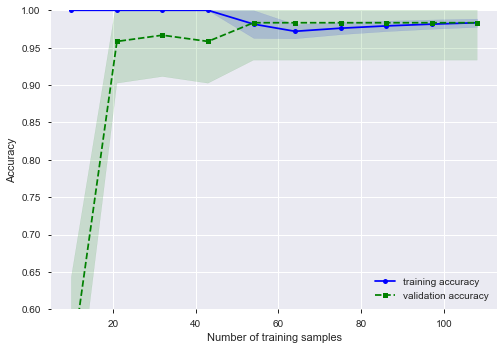


 Knn Learning Curve


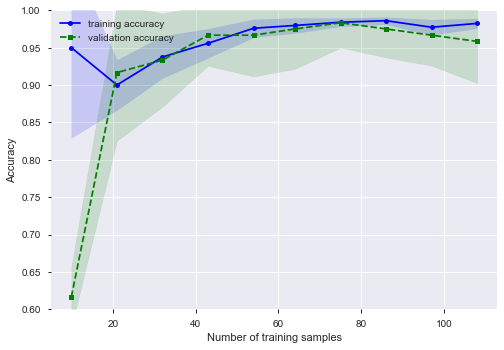

In [23]:
#Plot Learning Curve
print('LDA Learning Curve')
plot_learning_curves(pipe_lda)
print('\n Knn Learning Curve')
plot_learning_curves(pipe_knn)

Model Evaluation - Recall Score
LDA 0.98 +/- 0.03




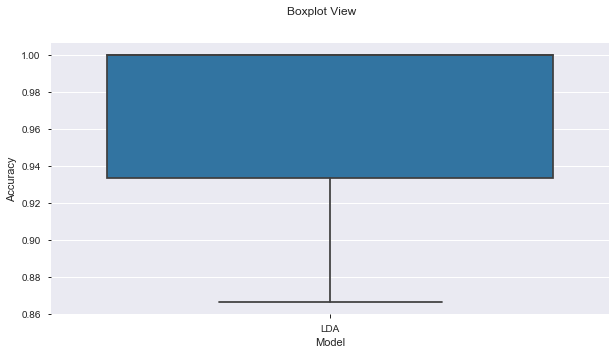

In [12]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LDA',pipe_lda))

#Model Evaluation
results =[]
names=[]
scoring ='accuracy'
print('Model Evaluation - Recall Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,Y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n') 

fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [13]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train2, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Validation Statistics
    target_names=['setosa','versicolor','virginica']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')

In [14]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Best Parameters: {'clf__solver': 'svd'}

 [[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]

               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


NestedCV Accuracy(weighted) :0.98 +/-0.03 
NestedCV Precision(weighted) :0.98 +/-0.03 
NestedCV Recall(weighted) :0.98 +/-0.03 



Optimized Model

Model Name: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Best P

LDA

Permutation Importance




Weight,Feature
0.4667 ± 0.1116,petal_length
0.2733 ± 0.1543,petal_width
0.0200 ± 0.0533,sepal_length
0.0067 ± 0.0267,sepal_width


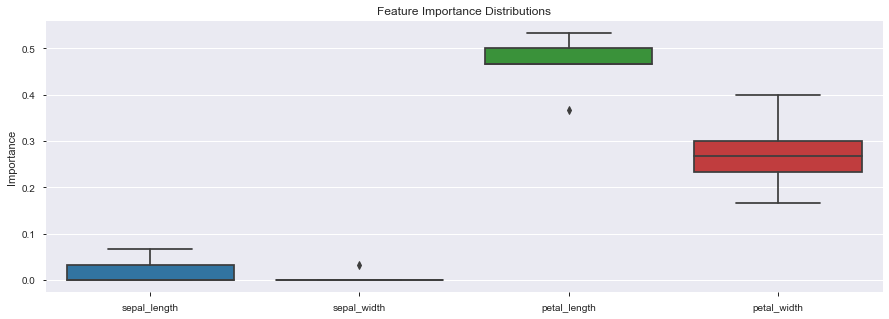

In [15]:
#Next Step - Feature Importance
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

for name, model in models:
    print(name)
    perm=PermutationImportance(model.fit(x_train2,y_train_smt),random_state=100).fit(x_test2,y_test)
    features=dataset.drop('species', axis=1).columns
    print('\nPermutation Importance')
    print('\n')
    df=eli5.show_weights(perm,feature_names=dataset.drop('species', axis=1).columns.tolist())
    display(df)
    df2= pd.DataFrame(data=perm.results_,columns=features)
    fig = plt.figure(figsize=(15,5))
    sns.boxplot(data=df2).set(title='Feature Importance Distributions',
                             ylabel='Importance')
    plt.show()

In [21]:
#Search for an optimal value of K for KNN
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1, 10)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    #obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, x_train2, y_train, cv=10, scoring='accuracy')
    #append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
    
#Print Best Score
BestScore = [1 - x for x in k_scores]
best_k = k_range[BestScore.index(min(BestScore))]
print('Optimal Number of Neighbors: {}'.format(best_k))

Optimal Number of Neighbors: 7


In [24]:
#Create Optimal KNN model
classifier = KNeighborsClassifier(n_neighbors = best_k)

#Fit KNN Model
classifier.fit(x_train2, y_train_smt)

#Prediction
y_pred = classifier.predict(x_test2)

#Evaluate the Algorithm
from sklearn.metrics import classification_report, confusion_matrix  
target_names=['setosa','versicolor','virginica']
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred,target_names=target_names))

[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [18]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier(n_jobs=-1))])

In [19]:
# Set grid search params 


#k-NN
param_range_k = range(1, 10) 
param_gridknn = {'clf__n_neighbors':param_range_k}

#Optimize Models 


opt_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_gridknn,
                       cv=10, verbose=0,scoring='accuracy',n_jobs=-1)

# List of pipelines for ease of iteration 
grids = [opt_knn] 

# Dictionary of pipelines and classifier types for ease of reference 
grid_dict = {0: 'kNN'}

In [20]:
# Create Confusion Matrix Table and Report
from sklearn.metrics import classification_report, confusion_matrix  

for idx, gs in enumerate(grids):
    
    #Fit grid search
    gs.fit(x_train2, y_train)
    # Predict on test data with best params 
    y_pred2 = gs.predict(x_test2) 
    
    #Create Dataframe to Compare Models
    target_names=['setosa','versicolor','virginica']
    print('\nEstimator: {}'.format(grid_dict[idx])) 
    print('\nBest Parameters:',str(gs.best_params_))
    print('\n', confusion_matrix(y_test,y_pred2))  
    print(classification_report(y_test,y_pred2,target_names=target_names)) 


Estimator: kNN

Best Parameters: {'clf__n_neighbors': 7}

 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

